## COMPLEMENT A L'ARTICLE

Nous vous proposons ici un programme implémentant un modèle simple de régression linéaire en Python pour prédire la solubilité dans l'eau de certaines molécules (c'est-à-dire les valeurs LogS). Il convient de noter que la solubilité est une propriété physico-chimique importante dans la découverte, la conception et le développement de drogues (ou de médicaments).

Pour réaliser notre programme, nous avons pris comme data set le jeu de données de solubilité de Delaney : https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

In [7]:
"""
    Nous allons lire le jeu de données téléchargé
"""
import pandas as pd
data = pd.read_csv('C:/Users/momo/Desktop/Projet - Perso/Drug Discovery/delaney.csv')
data

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [19]:
"""
    On peut décider de n'afficher que la colonne des notations SMILES
"""
print(data.SMILES, "\n")

# On peut aussi afficher aussi une valeur particulière dans la colonne SMILES
print("La prémière valeur : ",data.SMILES[0]) # On décide d'afficher la première valeur

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object 

La prémière valeur :  ClCC(Cl)(Cl)Cl


In [23]:
"""
    Grâce à la Bibliothèque RDKit, on peut créer un objet de type mol (structure de données associée à une molécule)
    à partir des notations SMILES et à cet objet, on peut appliquer des fonctions élémentaires.
"""
from rdkit import Chem

liste_mol = [] # On va plus tard utiliser cette liste
for target in data.SMILES:
    molecule = Chem.MolFromSmiles(target)
    liste_mol.append(molecule)
    
# On vérifie que tous les SMILES ont été convertis en mol
print(len(liste_mol)) # On doit normalement obtenir 1144

1144


-----
### Calcul des descripteurs
Nous allons maintenant représenter chacune des molécules du data set par un ensemble de descripteurs moléculaires qui seront utilisés pour la construction du modèle.

Pour prédire le LogS (log de la solubilité dans l'eau), l'étude de Delaney utilise 4 descripteurs moléculaires:
- cLogP (coefficient de partage octanol-eau)
- MW : Molecular Weight (ou poids moléculaire)
- RB : Rotatable Bounds (ou nombre de liaisons rotatives)
- AP : Aromatic Proportion (ou proportion aromatique = nombre d'atomes aromatiques / nombre d'atomes lourds)

Malheureusement, RDKit ne peut calculer que les trois (03) premières valeurs. Nous allons donc calculer le AP manuellement.

In [30]:
"""
    Nous allons maintetant créer une fonction pour calculer les trois (03) premiers descripteurs que sont :
    cLogP, MW et RB.
"""
import numpy as np
from rdkit.Chem import Descriptors
# Inspiré de : https://codeocean.com/explore/capsules?query=tag:data-curation

def generateur(smiles, verbose=False):

    liste_mol = []
    for target in smiles:
        mol =Chem.MolFromSmiles(target) 
        liste_mol.append(mol)
       
    baseData= np.arange(1,1)
    i = 0  
    for mol in liste_mol:        
       
        cLogP = Descriptors.MolLogP(mol)
        MW = Descriptors.MolWt(mol)
        RB = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([cLogP, MW, RB])   
    
        if(i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i+=1      
    
    nom_col = ["cLogP","MW","RB"]   
    descripteurs = pd.DataFrame(data = baseData, columns = nom_col)
    
    return descripteurs

In [31]:
"""
    Appliquons generate() à data.SMILES
"""
df = generateur(data.SMILES)
df

,cLogP,MW,RB
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [33]:
"""
    Ici, nous allons créer une fonction AromaticAtoms() pour calculer le nombre d'atomes aromatiques dans une molécule. 
    Nous allons utiliser cette valeur pour calculer ultérieurement le descripteur AP.
"""
def AromaticAtoms(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    compteur = []
    for i in aromatic_atoms:
        if i == True:
            compteur.append(1)
    somme = sum(compteur)
    return somme

In [58]:
"""
    On va maintenant calculer le descripteur AP. Pour se faire : 
    - on va appliquer notre fonction AromaticAtoms() sur la colonne SMILES de notre data set,
    - on utilisera aussi une fonction de RDKit pour calculer le nombre d'atomes lourds
    - et enfin on fait le ratio
"""
AP = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in liste_mol] # vous vous souvenez de liste_mol :)

In [63]:
"""
    On va ajouter le descripteur AP au tableau précedent 
""" 
df_AP = pd.DataFrame({"AP" : AP})
X = pd.concat([df, df_AP], axis=1) # La matrice X contient les 4 descripteurs

X

In [69]:
"""
    Nous allons maintenant créer une matrice Y qui servira à la prédiction de la valeur LogS.
    Dans la trame de données data, les valeurs LogS sont contenues dans la colonne : measured log(solubility:mol/L).
    C'est la deuxième colonne du tableau data (index 1).
"""
Y = data.iloc[:,1]
print(Y)

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64


---
### Régression Linéaire
Nous allons maintenant utiliser la régression linéaire pour faire la prédiction des logS. Mais avant, nous allons diviser notre data set (pour éviter du surapprentissage) en deux (02) lots : un pour l'entrainement et un autre pour le test.

In [71]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# On a décidé d'utiliser 75% des données pour l'apprentissage et les 25% restants pour le test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# On fait l'entrainement
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [74]:
"""
   - Coefficients :  liste les valeurs des coefficients de régression de chaque variable indépendante
   - Intercept : Valeur moyenne de Y quand X = 0
   - Erreur Quadratique Moyenne (EQM) : l'erreur de prédiction
   - Coefficient de détermination (R^2) : il s'agit du carré de la valeur du coefficient de corrélation de Pearson.
       Il est utilisée comme mesure de la qualité de la prédiction.
"""

Y_pred_train = model.predict(X_train)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Erreur Quadratique Moyenne (EQM): %.2f'% mean_squared_error(Y_train, Y_pred_train))
print('Coefficient de détermination (R^2): %.2f'% r2_score(Y_train, Y_pred_train))

Coefficients: [-0.77444521 -0.00638542  0.02924584 -0.262964  ]
Intercept: 0.1946696845273701
Erreur Quadratique Moyenne (EQM): 0.99
Coefficient de détermination (R^2): 0.77


In [75]:
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Erreur Quadratique Moyenne (EQM): %.2f'% mean_squared_error(Y_test, Y_pred_test))
print('Coefficient de détermination (R^2): %.2f'% r2_score(Y_test, Y_pred_test))

Coefficients: [-0.77444521 -0.00638542  0.02924584 -0.262964  ]
Intercept: 0.1946696845273701
Erreur Quadratique Moyenne (EQM): 1.09
Coefficient de détermination (R^2): 0.76


In [76]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]
print('LogS = ' + ' ' + yintercept + ' ' + LogP + ' ' + MW + ' ' + RB + ' ' + AP)

LogS =  0.19 -0.77 LogP -0.0064 MW 0.0292 RB -0.26 AP


---
### Affichage des valeurs
Visualisons maintenant la corrélation des valeurs de LogS expérimental avec celles des valeurs de LogS prédites au moyen du nuage de points. Nous afficherons les valeurs expérimentales et prédites de LogS séparément dans 2 nuages de points

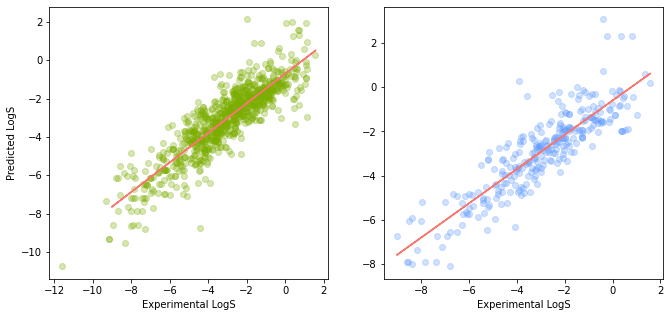

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()